In [ ]:
# !pip install --upgrade --force-reinstall --no-deps kaggle

In [ ]:
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler

import nltk
# nltk.download()
from nltk.tokenize import word_tokenize
import pandas as pd
import numpy as np
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, SpatialDropout1D

Downloading Kaggle dataset 

In [ ]:
# ! cp kaggle.json ~/.kaggle/
# ! chmod 600 ~/.kaggle/kaggle.json
# !kaggle datasets download -d 'datasnaek/youtube-new'
# !unzip /content/drive/Shareddrives/NEURALNETS/kaggle/youtube-new.zip

# Prep Code


## Data prep

In [ ]:
df = pd.read_csv("/content/drive/Shareddrives/NEURALNETS/kaggle/GBvideos.csv")

In [ ]:
features = df[['publish_time','category_id', 'title', 'description', 'views']]
features.head()

,publish_time,category_id,title,description,views
0,2017-11-10T07:38:29.000Z,26,John Lewis Christmas Ad 2017 - #MozTheMonster,Click here to continue the story and make your...,7224515
1,2017-11-12T06:24:44.000Z,24,Taylor Swift: …Ready for It? (Live) - SNL,Musical guest Taylor Swift performs …Ready for...,1053632
2,2017-11-10T17:00:03.000Z,10,Eminem - Walk On Water (Audio) ft. Beyoncé,Eminem's new track Walk on Water ft. Beyoncé i...,17158579
3,2017-11-13T02:30:38.000Z,17,Goals from Salford City vs Class of 92 and Fri...,Salford drew 4-4 against the Class of 92 and F...,27833
4,2017-11-13T01:45:13.000Z,25,Dashcam captures truck's near miss with child ...,Dashcam captures truck's near miss with child ...,9815


In [ ]:
features['publish_datetime']  = pd.to_datetime(features['publish_time'])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


Derive features from provided featyre "publish_datetime"

In [ ]:
features['day_of_year']  = features['publish_datetime'].dt.dayofyear
features['weekday']  = features['publish_datetime'].dt.day_name()
features['hour']  = features['publish_datetime'].dt.hour
features['minute']  = features['publish_datetime'].dt.minute
features['second']  = features['publish_datetime'].dt.second

# monday is day 0, sunday is day 6 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

In [ ]:
features.head()

,publish_time,category_id,title,description,views,publish_datetime,day_of_year,weekday,hour,minute,second
0,2017-11-10T07:38:29.000Z,26,John Lewis Christmas Ad 2017 - #MozTheMonster,Click here to continue the story and make your...,7224515,2017-11-10 07:38:29+00:00,314,Friday,7,38,29
1,2017-11-12T06:24:44.000Z,24,Taylor Swift: …Ready for It? (Live) - SNL,Musical guest Taylor Swift performs …Ready for...,1053632,2017-11-12 06:24:44+00:00,316,Sunday,6,24,44
2,2017-11-10T17:00:03.000Z,10,Eminem - Walk On Water (Audio) ft. Beyoncé,Eminem's new track Walk on Water ft. Beyoncé i...,17158579,2017-11-10 17:00:03+00:00,314,Friday,17,0,3
3,2017-11-13T02:30:38.000Z,17,Goals from Salford City vs Class of 92 and Fri...,Salford drew 4-4 against the Class of 92 and F...,27833,2017-11-13 02:30:38+00:00,317,Monday,2,30,38
4,2017-11-13T01:45:13.000Z,25,Dashcam captures truck's near miss with child ...,Dashcam captures truck's near miss with child ...,9815,2017-11-13 01:45:13+00:00,317,Monday,1,45,13


## Categorical Variables 

In [ ]:
features = pd.get_dummies(features, columns=['weekday'])
features = pd.get_dummies(features, columns=['category_id'])

In [ ]:
features['title_len'] = (features['title']).apply(len)
features = features.drop(columns=['publish_time', 'publish_datetime', 'description'])
column_to_move = features.pop("views")
features.insert(0, "views", column_to_move )
features.head()

,views,title,day_of_year,hour,minute,second,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,...,category_id_22,category_id_23,category_id_24,category_id_25,category_id_26,category_id_27,category_id_28,category_id_29,category_id_43,title_len
0,7224515,John Lewis Christmas Ad 2017 - #MozTheMonster,314,7,38,29,1,0,0,0,...,0,0,0,0,1,0,0,0,0,45
1,1053632,Taylor Swift: …Ready for It? (Live) - SNL,316,6,24,44,0,0,0,1,...,0,0,1,0,0,0,0,0,0,41
2,17158579,Eminem - Walk On Water (Audio) ft. Beyoncé,314,17,0,3,1,0,0,0,...,0,0,0,0,0,0,0,0,0,42
3,27833,Goals from Salford City vs Class of 92 and Fri...,317,2,30,38,0,1,0,0,...,0,0,0,0,0,0,0,0,0,76
4,9815,Dashcam captures truck's near miss with child ...,317,1,45,13,0,1,0,0,...,0,0,0,1,0,0,0,0,0,55


## Normalize data

In [ ]:
for col in features:

  if col == 'title':
    continue
  max = (features[col]).max()
  min = (features[col]).min()
  features[col] = 1 + (features[col] - min)/(max-min)


In [ ]:
features.head()

,views,title,day_of_year,hour,minute,second,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,...,category_id_22,category_id_23,category_id_24,category_id_25,category_id_26,category_id_27,category_id_28,category_id_29,category_id_43,title_len
0,1.017015,John Lewis Christmas Ad 2017 - #MozTheMonster,1.859890,1.304348,1.644068,1.491525,2.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.414894
1,1.002480,Taylor Swift: …Ready for It? (Live) - SNL,1.865385,1.260870,1.406780,1.745763,1.0,1.0,1.0,2.0,...,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.372340
2,1.040415,Eminem - Walk On Water (Audio) ft. Beyoncé,1.859890,1.739130,1.000000,1.050847,2.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.382979
3,1.000064,Goals from Salford City vs Class of 92 and Fri...,1.868132,1.086957,1.508475,1.644068,1.0,2.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.744681
4,1.000021,Dashcam captures truck's near miss with child ...,1.868132,1.043478,1.762712,1.220339,1.0,2.0,1.0,1.0,...,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.521277


## LSTM - Emotion Detection

## Load labelled emotion data 

In [ ]:
cd /content/drive/Shareddrives/NEURALNETS/isear

/content/drive/Shareddrives/NEURALNETS/isear


In [ ]:
dflabelledog = pd.read_csv("/content/drive/Shareddrives/NEURALNETS/isear/eng_dataset.csv")

dflabelled = pd.read_csv("/content/drive/Shareddrives/NEURALNETS/tweet_emotions.csv")

dflabelled2 = pd.read_csv("/content/drive/Shareddrives/NEURALNETS/test.csv")



In [ ]:
dflabelled.head()

,sentiment,content
0,anger,fuckin'm transtelecom
1,anger,Working But it's Fridaaaayyyyy
2,anger,Packing I don't like it..
3,anger,I tried to dye my hair and all i got was a blo...
4,anger,&quot;locked up abroad&quot; makes bein half b...


In [ ]:
dflabelled.sentiment.unique()

array(['anger', 'boredom', 'empty', 'enthusiasm', 'fun', 'happiness',
       'hate', 'love', 'neutral', 'relief', 'sadness', 'surprise',
       'worry'], dtype=object)

In [ ]:
dflabelled.sentiment.value_counts()

neutral       8638
worry         8459
happiness     5209
sadness       5165
love          3842
surprise      2187
fun           1776
relief        1526
hate          1323
empty          827
enthusiasm     759
boredom        179
anger          110
Name: sentiment, dtype: int64

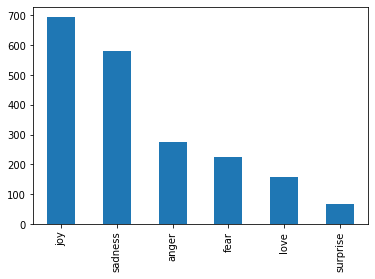

In [ ]:
dflabelled2.sentiment.value_counts().plot(kind='bar', stacked=False)

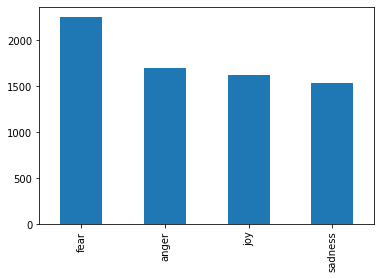

In [ ]:
dflabelledog.sentiment.value_counts().plot(kind='bar', stacked=False)

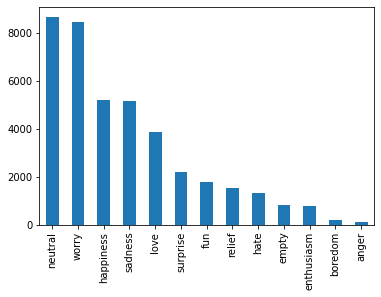

In [ ]:
dflabelled.sentiment.value_counts().plot(kind='bar', stacked=False)

## Cleanse data

In [ ]:
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
#data cleaning
clean_data = []

# start cleaning data
for text in dflabelled['content']:
    tokens = word_tokenize(text) # split the tokens
    tokens = [w.lower() for w in tokens] # convert to lower case

    import string
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    words = [word for word in stripped if word.isalpha()] # filter all the punciations

    
    # filtering stop words
    from nltk.corpus import stopwords
    stop_words = stopwords.words('english')

    words = [w for w in words if not w in stop_words]

    # stemming of words
    from nltk.stem.porter import PorterStemmer
    porter = PorterStemmer()
    stemmed_words = [porter.stem(word) for word in words]

    clean_text = ''
    for w in stemmed_words:
        clean_text += ' ' + w
    clean_data.append(clean_text)

print('Clean data created')
dflabelled['clean_tweet'] = clean_data


Clean data created


In [ ]:
dflabelled

,sentiment,content,clean_tweet
0,anger,fuckin'm transtelecom,fuckin transtelecom
1,anger,Working But it's Fridaaaayyyyy,work fridaaaayyyyy
2,anger,Packing I don't like it..,pack nt like
3,anger,I tried to dye my hair and all i got was a blo...,tri dye hair got blond chunk front middl part...
4,anger,&quot;locked up abroad&quot; makes bein half b...,quot lock abroad quot make bein half brown go...
...,...,...,...
39995,worry,tomorrow is going to be sooo awkward &amp; emb...,tomorrow go sooo awkward amp embarass light a...
39996,worry,"@icebergstorm hey! negative on the primatech, ...",icebergstorm hey neg primatech handl tube dec...
39997,worry,@PH7S sure. But be careful also of making stat...,sure care also make statement nt parallel ide...
39998,worry,How Do You Sleep - Jesse McCartney,sleep jess mccartney


texts_to_sequences Transforms each text in texts to a sequence of integers. So it basically takes each word in the text and replaces it with its corresponding integer value from the word_index dictionary. 
https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer 

In [ ]:
# tokenization
max_words = 2000
tokenizer = Tokenizer(num_words=max_words, split=' ')
tokenizer.fit_on_texts(dflabelled['clean_tweet'].values)
X = tokenizer.texts_to_sequences(dflabelled['clean_tweet'].values)
X = pad_sequences(X, maxlen=32)
print(X.shape[1])

32


In [ ]:
fisrt_sentence = tokenizer.texts_to_sequences(['At the point today where if someone says something remotely kind to me, a waterfall will burst out of my eyes'])
fisrt_sentence

[[488, 12, 385]]

In [ ]:
fisrt_sentence_clean = tokenizer.texts_to_sequences(['point today someon say someth remot kind waterfal burst eye'])
fisrt_sentence_clean

[[488, 12, 167, 61, 134, 385, 372]]

In [ ]:
X[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0, 202,  34,
        47,  33,  72, 345, 366, 444], dtype=int32)


## Build LSTM

In [ ]:
enbedding_out_dim = 256
lstm_out_dim = 256

model = Sequential()
model.add(Embedding(max_words, enbedding_out_dim,input_length = X.shape[1]))
model.add(LSTM(lstm_out_dim+1))
model.add(Dense(13,activation='softmax'))
model.compile(loss = 'categorical_crossentropy', optimizer='adam',metrics = ['accuracy'])
print(model.summary())

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_5 (Embedding)     (None, 32, 256)           512000    
                                                                 
 lstm_5 (LSTM)               (None, 257)               528392    
                                                                 
 dense_5 (Dense)             (None, 13)                3354      
                                                                 
Total params: 1,043,746
Trainable params: 1,043,746
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
# crete categorical variables 
dummies = pd.get_dummies(dflabelled['sentiment'])
Y = dummies.values
# train and test set 
#random state 50 ---> same train test split each time 

# shuffle??
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.2, random_state = 50)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(32000, 32) (32000, 13)
(8000, 32) (8000, 13)


In [ ]:
dict_emotion = {}
dict_label = {}
for i in range(len(Y)):
    dict_emotion[dflabelled['sentiment'][i]] = np.argmax(Y[i])
    dict_label[np.argmax(Y[i])] = dflabelled['sentiment'][i]
    if len(dict_emotion) == 4:
        print('Break at: ', i)
        break

print(dict_emotion, dict_label)

Break at:  1116
{'anger': 0, 'boredom': 1, 'empty': 2, 'enthusiasm': 3} {0: 'anger', 1: 'boredom', 2: 'empty', 3: 'enthusiasm'}


In [ ]:
X_train[0]

array([ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
        0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, 35, 85,  2, 12],
      dtype=int32)

In [ ]:
X_train[3]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,  154,  708,  189,   31, 1128],
      dtype=int32)

In [ ]:
X_train, X_val, Y_train, Y_val = train_test_split(X_train,Y_train, test_size = 0.2, random_state = 50)


In [ ]:
print(X_train.shape,Y_train.shape)
print(X_val.shape,Y_val.shape)

(25600, 32) (25600, 13)
(6400, 32) (6400, 13)


## Train, Validate, Test

In [ ]:
# train the net
### reduce the epocs this is mad
batch_size = 512
history = model.fit(X_train,Y_train, 
                    epochs = 100, 
                    batch_size=batch_size,
                    validation_data=(X_val, Y_val))

Epoch 1/100
50/50 [==============================] - 6s 65ms/step - loss: 2.1652 - accuracy: 0.2472 - val_loss: 2.0680 - val_accuracy: 0.2795
Epoch 2/100
50/50 [==============================] - 2s 50ms/step - loss: 1.9658 - accuracy: 0.3323 - val_loss: 1.9260 - val_accuracy: 0.3481
Epoch 3/100
50/50 [==============================] - 2s 50ms/step - loss: 1.8449 - accuracy: 0.3775 - val_loss: 1.9019 - val_accuracy: 0.3569
Epoch 4/100
50/50 [==============================] - 3s 52ms/step - loss: 1.7765 - accuracy: 0.4026 - val_loss: 1.9048 - val_accuracy: 0.3559
Epoch 5/100
50/50 [==============================] - 2s 49ms/step - loss: 1.7254 - accuracy: 0.4178 - val_loss: 1.9253 - val_accuracy: 0.3536
Epoch 6/100
50/50 [==============================] - 3s 52ms/step - loss: 1.6813 - accuracy: 0.4306 - val_loss: 1.9493 - val_accuracy: 0.3445
Epoch 7/100
50/50 [==============================] - 3s 52ms/step - loss: 1.6426 - accuracy: 0.4420 - val_loss: 1.9707 - val_accuracy: 0.3406
Epoch 

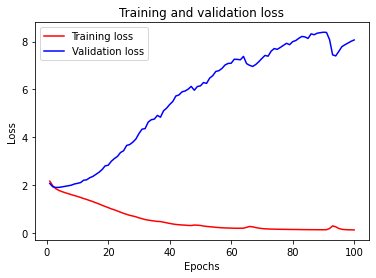

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# validation
total, correct, false = 0, 0, 0

for x in range(len(X_val)):
    total += 1


    result = model.predict(X_val[x].reshape(1, X_test.shape[1]), batch_size=1)[0]


    if np.argmax(result) == np.argmax(Y_val[x]):
        correct += 1

    else:
        false += 1
print("accuracy", correct / total * 100, "%")


In [ ]:
# test
total, correct, false = 0, 0, 0

for x in range(len(X_test)):
    total += 1


    result = model.predict(X_test[x].reshape(1, X_test.shape[1]), batch_size=1)[0]


    if np.argmax(result) == np.argmax(Y_test[x]):
        correct += 1

    else:
        false += 1
print("accuracy", correct / total * 100, "%")

accuracy 25.4 %


In [ ]:
result

array([4.4001204e-08, 3.1782044e-08, 9.9999988e-01, 1.8111351e-08],
      dtype=float32)

In [ ]:
Y_test[x]

array([0, 0, 1, 0], dtype=uint8)

## Predict Senitment of Video Titles

In [ ]:
features.title

0            John Lewis Christmas Ad 2017 - #MozTheMonster
1                Taylor Swift: …Ready for It? (Live) - SNL
2               Eminem - Walk On Water (Audio) ft. Beyoncé
3        Goals from Salford City vs Class of 92 and Fri...
4        Dashcam captures truck's near miss with child ...
                               ...                        
38911    Enrique Iglesias - MOVE TO MIAMI (Official Vid...
38912    Jacob Sartorius - Up With It (Official Music V...
38913                   Anne-Marie - 2002 [Official Video]
38914    Eleni Foureira - Fuego - Cyprus - LIVE - First...
38915    KYLE - Ikuyo feat.  2 Chainz & Sophia Black [A...
Name: title, Length: 38916, dtype: object

In [ ]:
# subset = title.head(38916)

In [ ]:
#data cleaning
clean_data = []

# start cleaning data
for text in features['title']:
    tokens = word_tokenize(text) # split the tokens
    tokens = [w.lower() for w in tokens] # convert to lower case

    import string
    table = str.maketrans('', '', string.punctuation)
    stripped = [w.translate(table) for w in tokens]
    words = [word for word in stripped if word.isalpha()] # filter all the punciations

    
    # filtering stop words
    from nltk.corpus import stopwords
    stop_words = stopwords.words('english')

    words = [w for w in words if not w in stop_words]

    # stemming of words
    from nltk.stem.porter import PorterStemmer
    porter = PorterStemmer()
    stemmed_words = [porter.stem(word) for word in words]

    clean_text = ''
    for w in stemmed_words:
        clean_text += ' ' + w
    clean_data.append(clean_text)

print('Clean data created')
features['clean_title'] = clean_data

Clean data created


In [ ]:
# tokenization
max_words = 2000
tokenizer = Tokenizer(num_words=max_words, split=' ')
tokenizer.fit_on_texts(features['clean_title'].values)
VidTitle = tokenizer.texts_to_sequences(features['clean_title'].values)
VidTitle = pad_sequences(VidTitle, maxlen=32)
print(VidTitle.shape[1])

32


In [ ]:
# predict
Video_Emotion = []
for x in range(len(VidTitle)):
    result = model.predict(VidTitle[x].reshape(1, X_test.shape[1]), batch_size=1)[0]
    Video_Emotion.append(np.argmax(result))
    if x%500 == 0:
      print('iteration complete: ', x+1)


iteration complete:  1
iteration complete:  501
iteration complete:  1001
iteration complete:  1501
iteration complete:  2001
iteration complete:  2501
iteration complete:  3001
iteration complete:  3501
iteration complete:  4001
iteration complete:  4501
iteration complete:  5001
iteration complete:  5501
iteration complete:  6001
iteration complete:  6501
iteration complete:  7001
iteration complete:  7501
iteration complete:  8001
iteration complete:  8501
iteration complete:  9001
iteration complete:  9501
iteration complete:  10001
iteration complete:  10501
iteration complete:  11001
iteration complete:  11501
iteration complete:  12001
iteration complete:  12501
iteration complete:  13001
iteration complete:  13501
iteration complete:  14001
iteration complete:  14501
iteration complete:  15001
iteration complete:  15501
iteration complete:  16001
iteration complete:  16501
iteration complete:  17001
iteration complete:  17501
iteration complete:  18001
iteration complete:  1850



*   0- anger

* 1- fear
* 2- joy
* 3- sadness


In [ ]:
features['title'][3009]

"Ellen Makes 'Friends' with BTS!"

In [ ]:
Video_Emotion[3009]

1

In [ ]:
features['Title_emotion'] = Video_Emotion

In [ ]:
features.to_csv('/content/drive/Shareddrives/NEURALNETS/features.csv')

In [ ]:
testload = pd.read_csv('/content/drive/Shareddrives/NEURALNETS/features.csv')

# LSTM - View Prediction

In [ ]:
Data = pd.read_csv('/content/drive/Shareddrives/NEURALNETS/features.csv')
Data.head()

,Unnamed: 0,views,title,day_of_year,hour,minute,second,weekday_Friday,weekday_Monday,weekday_Saturday,...,category_id_24,category_id_25,category_id_26,category_id_27,category_id_28,category_id_29,category_id_43,title_len,clean_title,Title_emotion
0,0,1.017015,John Lewis Christmas Ad 2017 - #MozTheMonster,1.859890,1.304348,1.644068,1.491525,2.0,1.0,1.0,...,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.414894,john lewi christma ad mozthemonst,2
1,1,1.002480,Taylor Swift: …Ready for It? (Live) - SNL,1.865385,1.260870,1.406780,1.745763,1.0,1.0,1.0,...,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.372340,taylor swift live snl,1
2,2,1.040415,Eminem - Walk On Water (Audio) ft. Beyoncé,1.859890,1.739130,1.000000,1.050847,2.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.382979,eminem walk water audio ft beyoncé,1
3,3,1.000064,Goals from Salford City vs Class of 92 and Fri...,1.868132,1.086957,1.508475,1.644068,1.0,2.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.744681,goal salford citi vs class friend peninsula s...,0
4,4,1.000021,Dashcam captures truck's near miss with child ...,1.868132,1.043478,1.762712,1.220339,1.0,2.0,1.0,...,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.521277,dashcam captur truck near miss child norway,2


### Removal of text fields PCA

In [ ]:
from sklearn.decomposition import PCA

Data.pop("title")
Data.pop("clean_title")


# create dummies for emotion 
Data.head()


,Unnamed: 0,views,day_of_year,hour,minute,second,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,...,category_id_23,category_id_24,category_id_25,category_id_26,category_id_27,category_id_28,category_id_29,category_id_43,title_len,Title_emotion
0,0,1.017015,1.859890,1.304348,1.644068,1.491525,2.0,1.0,1.0,1.0,...,1.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.414894,2
1,1,1.002480,1.865385,1.260870,1.406780,1.745763,1.0,1.0,1.0,2.0,...,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,1.372340,1
2,2,1.040415,1.859890,1.739130,1.000000,1.050847,2.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.382979,1
3,3,1.000064,1.868132,1.086957,1.508475,1.644068,1.0,2.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.744681,0
4,4,1.000021,1.868132,1.043478,1.762712,1.220339,1.0,2.0,1.0,1.0,...,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1.521277,2


## create NN for view prediction

In [ ]:
from tensorflow.keras.layers import Input, Dense, Activation,Dropout
from tensorflow.keras.models import Model
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split

In [ ]:
# test and training sets 
X = Data.iloc[:, 2:31].values
y = Data.iloc[:, 1].values
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.2)
# default shuffle = true 

In [ ]:
X

array([[1.85989011, 1.30434783, 1.6440678 , ..., 1.        , 1.41489362,
        2.        ],
       [1.86538462, 1.26086957, 1.40677966, ..., 1.        , 1.37234043,
        1.        ],
       [1.85989011, 1.73913043, 1.        , ..., 1.        , 1.38297872,
        1.        ],
       ...,
       [1.3489011 , 1.47826087, 1.08474576, ..., 1.        , 1.29787234,
        3.        ],
       [1.3489011 , 1.86956522, 1.54237288, ..., 1.        , 1.73404255,
        0.        ],
       [1.35714286, 1.17391304, 1.10169492, ..., 1.        , 1.4787234 ,
        1.        ]])

In [ ]:
y

array([1.01701535, 1.00247983, 1.04041505, ..., 1.06981838, 1.03372292,
       1.00142909])

In [ ]:
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

In [ ]:
# build and train model
input_layer = Input(shape=(X.shape[1],))
dense_layer_1 = Dense(500, activation='relu')(input_layer)
#dense_layer_2 = Dense(100, activation='relu')(dense_layer_1)
#dense_layer_3 = Dense(25, activation='relu')(dense_layer_2)
#output = Dense(1)(dense_layer_3)
output = Dense(1)(dense_layer_1)

model = Model(inputs=input_layer, outputs=output)
#model.compile(loss="mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])
model.compile(loss = 'mean_squared_error', optimizer='adam',metrics = ['accuracy'])
# model.compile(loss="mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])

In [ ]:
# epochs = 100
history = model.fit(X_train, y_train, batch_size=2, epochs=50, verbose=1, validation_split=0.2)

Epoch 1/50
12453/12453 [==============================] - 38s 3ms/step - loss: 0.0034 - accuracy: 4.0153e-05 - val_loss: 0.0018 - val_accuracy: 0.0000e+00
Epoch 2/50
12453/12453 [==============================] - 36s 3ms/step - loss: 0.0024 - accuracy: 4.0153e-05 - val_loss: 0.0017 - val_accuracy: 0.0000e+00
Epoch 3/50
12453/12453 [==============================] - 35s 3ms/step - loss: 0.0022 - accuracy: 4.0153e-05 - val_loss: 0.0016 - val_accuracy: 0.0000e+00
Epoch 4/50
12453/12453 [==============================] - 35s 3ms/step - loss: 0.0021 - accuracy: 4.0153e-05 - val_loss: 0.0017 - val_accuracy: 0.0000e+00
Epoch 5/50
12453/12453 [==============================] - 36s 3ms/step - loss: 0.0021 - accuracy: 4.0153e-05 - val_loss: 0.0017 - val_accuracy: 0.0000e+00
Epoch 6/50
12453/12453 [==============================] - 35s 3ms/step - loss: 0.0020 - accuracy: 4.0153e-05 - val_loss: 0.0017 - val_accuracy: 0.0000e+00
Epoch 7/50
12453/12453 [==============================] - 36s 3ms/step

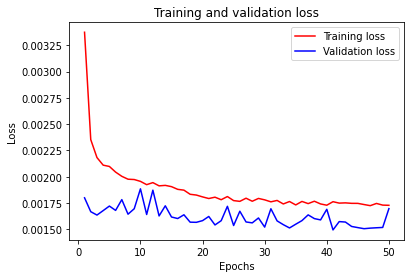

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# predict test set 
result = []
er = 0 
for x in range(len(X_test)):
  result.append(model.predict(X_test[x].reshape(1, X_test.shape[1]), batch_size=1)[0])
  error = abs(y_test[x] - result[x]) 
  er = er + error

er = er / len(X_test)
print(er)


In [ ]:
# predict test set 
result = []

for x in range(len(X_test)):
  result.append(model.predict(X_test[x].reshape(1, X_test.shape[1]), batch_size=1)[0])

mse = ((y_test - result)**2).mean(axis=None)
mse

0.0030274139117613796

# Compare with NN for view prediction - without emotion labelled data 

In [ ]:
from tensorflow.keras.layers import Input, Dense, Activation,Dropout
from tensorflow.keras.models import Model
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, accuracy_score
from sklearn.model_selection import train_test_split

In [ ]:
# test and training sets 
X = Data.iloc[:, 2:30].values
y = Data.iloc[:, 1].values
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.2)
# default shuffle = true 

In [ ]:
X[0]

array([0.85989011, 0.30434783, 0.6440678 , 0.49152542, 1.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       0.        , 0.        , 0.41489362])

In [ ]:
y

array([0.01701535, 0.00247983, 0.04041505, ..., 0.00183548, 0.00170645,
       0.00030361])

In [ ]:
# sc = StandardScaler()
# X_train = sc.fit_transform(X_train)
# X_test = sc.transform(X_test)

In [ ]:
# build and train model
input_layer = Input(shape=(X.shape[1],))
dense_layer_1 = Dense(500, activation='relu')(input_layer)
#dense_layer_2 = Dense(100, activation='relu')(dense_layer_1)
#dense_layer_3 = Dense(25, activation='relu')(dense_layer_2)
#output = Dense(1)(dense_layer_3)
output = Dense(1)(dense_layer_1)

model = Model(inputs=input_layer, outputs=output)
#model.compile(loss="mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])
model.compile(loss = 'mean_squared_error', optimizer='adam',metrics = ['accuracy'])
# model.compile(loss="mean_squared_error" , optimizer="adam", metrics=["mean_squared_error"])

In [ ]:
# epochs = 100
history = model.fit(X_train, y_train, batch_size=2, epochs=50, verbose=1, validation_split=0.2)

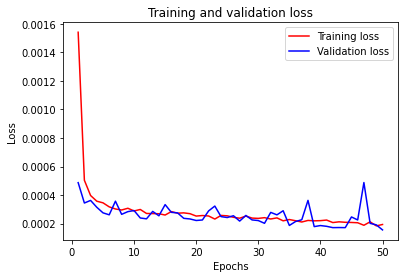

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# predict test set 
result = []
for x in range(len(X_test)):
  result.append(model.predict(X_test[x].reshape(1, X_test.shape[1]), batch_size=1)[0])



In [ ]:
error = y_test - result 
error


In [ ]:
mse = ((y_test - result)**2).mean(axis=None)
mse

0.0007382186158726178